## Stage 2: Research

### Research Goal: To gather and contain all the context requested in the research brief

- Structure: Research Brief >> Research [LLM >> Tools >> (Response) >> LLM]
- The LLM >> Tool Loop will continue till the Agent decides that the action is completed and no more tool call is required

- Research Agent Pattern:
    - 1. LLM Decision Node: Analyzes current state and decides whether to perform a tool call or final response
    - 2. Tool Execution Node: Executes the serach tool when LLM requires more information
    - 3. Research Compression Node: Summarizes and compresses research findings or efficient processing
    - 4. Routing Logic: Determines the workflow based on LLM decisions

### Prompting the Agent

- So that the Agent does not perform excessive tool calls and maintains focus while performing the research task

- Agent Prompting Techniques:
    - 1. Think Like an Agent
        - Read the Question carefully: Assess the specific information the user needs
        - Perform Broader Searches: Use broad comprehensive queries first
        - Pause & Assess Period: After each researc reflect and see if adequate information is present/missing
        - Perform Narrower Searches: Use narrow searches to fill in the gaps for missing information

    - 2. Concrete Limitations
        - Confidence State: Stop searching when the Agent is confident of the answer
        - Budget Allocation: Use 2-3 search tools for simple queries and 5 for complex queries
        - Limits: Always stop after 5 iterations if your not able to find the right source/s

    - 3. Display Thinking (Pros: For Analyzing and Debugging Agent Behaviour)
        - Perform thinking about tool analyzes after every tool search is performed:
            - Check if all information required is present
            - Check if any information is missing
            - Check if the question can be answer using the information present
            - Evaluate if more information/ tool calling is required to answer the question 

In [1]:
from research_utils import show_prompt
from deep_research_prompts.prompts import research_agent_prompt
show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

### State and Schemas

- Here, we will define the state and schemas for the research agent
- Create the agent state object and respective schemas

In [ ]:
%%writefile state_research.py

## Create the agent state object and respective schemas for research agent

"""
State Definitions and Pydantic Schemas for Research Agent

This module defines the state objects and structured schemas used for
the research agent workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

## STATE DEFINITIONS

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.
    
    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.
    
    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

## STRUCTURED OUTPUT SCHEMAS

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

### Research Tools

- Tavily Search: It is a serach engine optimized for AI applications

- Features:
    - Real-time web search results
    - Content extraction and summarization
    - Domain filtering and result ranking
    - Async support for performance

- LangChain Tools: Helps convert the results obtained from Tavily into a LangChain Tool (@tool decorator)

- Features:
    - Automatic schema generation for the LLM
    - Integration with LangChain's agent framework
    - Standardized tool calling interface
    - Type validation and documentation

### Context Engineering Strategy

- Structure: WebPage Summarization >> Research Compression >> Compression Evaluation >> Output Token Management

- Context Engineering Stages:
    - WebPage Summarization: Extracts, Filters and Compresses information from the entire webpage for research efficiency
    - Research Compression: Applying compression to delete the noise and extract only relevant information
    - Compression Evaluation: Evaluates whether any important information is lost during the compression stage
    - Output Token Management: Evaluates the response length and checks token limits for the output response

In [ ]:
%%writefile research_agent.py

## Research Agent Workflow
## This defines the entire workflow (nodes, edges and graph) the research agent performs

"""Research Agent Implementation.

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message

## CONFIGURATION

# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
model = init_chat_model(model="ollama:llama3.1:8b")
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model="ollama:granite3.3:8b")
compress_model = init_chat_model(model="ollama:granite3.3:8b", max_tokens=32000)

## AGENT NODES

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
 
    ## Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    ## Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)
    
    ## Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

## ROUTING LOGIC

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    ## If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    ## Else, we have a final answer
    return "compress_research"

## GRAPH CONSTRUCTION

## Build the agent workflow
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

## Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

## Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

## Compile the agent
researcher_agent = agent_builder.compile()

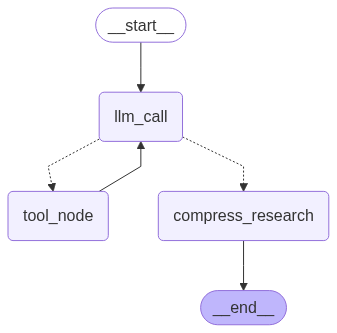

In [2]:
from IPython.display import Image, display
from research_agent import researcher_agent

## Display the agent workflow
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [3]:
## Run the agent
from research_utils import format_messages
from langchain_core.messages import HumanMessage

## Example brief
research_brief = """I want to identify and evaluate the coffee shops in Toronto that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the Downtown Toronto area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in Toronto, emphasizing their coffee quality according to the latest available data as  
of August 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in Toronto that are considered the best based specifically     │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the Downtown Toronto │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in Toronto, emphasizing their coffee quality according to the latest available data as     │
│ of August 2025..                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I need to identify and evaluate the best coffee shops in Downtown Toronto based on coffee      │
│ quality. I should prioritize primary sources like official websites, reputable third-party reviews, and         │
│ prominent review aggregators for customer feedback about coffee quality."                                       │
│ }                                                                                                               │
│    ID: 2147e230-452b-4d8a-a773-d0d29efceebc                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I need to identify and evaluate the best coffee shops in Downtown Toronto based on coffee  │
│ quality. I should prioritize primary sources like official websites, reputable third-party reviews, and         │
│ prominent review aggregators for customer feedback about coffee quality.                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops in Downtown Toronto by coffee quality"                                            │
│ }                                                                                                               │
│    ID: c0b3fee2-ed60-4090-b4e5-2859b221131b                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Best Coffee in Downtown Toronto 2024 | The Anndore House ---                                      │
│ URL: https://theanndorehouse.com/2024/01/best-coffee-downtown-toronto-2025/                                     │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The webpage discusses the best coffee shops in downtown Toronto. It highlights several cafes, including Scarlet │
│ Door, Goldstruck Coffee, Detour Coffee, and others. Each cafe has its unique atmosphere, menu offerings, and    │
│ specialties. The webpage also provides walking distances from a nearby hotel to each location.                  │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ Scarlet Door is known for its industrial-chic decor and specialty coffee drinks, while Goldstruck Coffee offers │
│ high-quality beans sourced directly from farmers. Detour Coffee has a cozy atmosphere and serves a variety of   │
│ teas and pastries.                                                                                              │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Downtown Coffee Shop Recommendations : r/FoodToronto - Reddit ---                                 │
│ URL: https://www.reddit.com/r/FoodToronto/comments/1fm6sqx/downtown_coffee_shop_recommendations/                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Sep 21, 2024·Dundas West from Bathurst to Trinity Bellwoods has some great cafes: Milky's, Sonndr and Hamers.   │
│ On College west of Spadina is Found.Best Coffee in Toronto? : r/askTOBest cafe for coffee in Toronto? :         │
│ r/FoodTorontoMore results from www.reddit.com                                                                   │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Based on the search results, I found several coffee shops in Downtown Toronto that are known   │
│ for their high-quality coffee, including Scarlet Door, Goldstruck Coffee, and Detour Coffee. However, I should  │
│ consider other factors such as expert reviews, customer ratings, and specialty coffee certifications to provide │
│ a more comprehensive evaluation of the top coffee shops in the area. I will also need to assess the credibility │
│ and relevance of these sources to ensure that my findings are accurate and reliable."                           │
│ }                                                                                                               │
│    ID: 2fec55d8-fdb6-4b0e-b63f-1ab4a5aa5a94                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Based on the search results, I found several coffee shops in Downtown Toronto that are     │
│ known for their high-quality coffee, including Scarlet Door, Goldstruck Coffee, and Detour Coffee. However, I   │
│ should consider other factors such as expert reviews, customer ratings, and specialty coffee certifications to  │
│ provide a more comprehensive evaluation of the top coffee shops in the area. I will also need to assess the     │
│ credibility and relevance of these sources to ensure that my findings are accurate and reliable.                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "coffee shop reviews from Specialty Coffee Association"                                              │
│ }                                                                                                               │
│    ID: 31a5a4b4-dc6b-4d36-8b22-cbb3dd9d1eba                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Specialty Coffee Association Reviews 2 - Trustpilot ---                                           │
│ URL: https://www.trustpilot.com/review/sca.coffee                                                               │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Rating2.9(2)2 people have already reviewed Specialty Coffee Association. Read about their experiences and share │
│ your own!                                                                                                       │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Specialty Coffee Association verification - Reddit ---                                            │
│ URL: https://www.reddit.com/r/Coffee/comments/1jfsjvn/specialty_coffee_association_verification/                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The post on r/Coffee discusses verifying claims of Specialty Coffee Association (SCA) ranking. A user asks for  │
│ a list of product scores issued by SCA to verify claims made by companies in the UK. The related answers        │
│ section includes topics such as coffee brewing methods, unique coffee beans, and essential coffee gear for home │
│ baristas.                                                                                                       │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ The Specialty Coffee Association verification is a crucial step in ensuring the quality of coffee products.     │
│ Companies making claims about their SCA ranking should be held accountable, stated AdventurousHost2575. The     │
│ user is interested in verifying claims AND keen to look at a list of product scores issued by the association.  │
│ I'm interest in verifying claims AND keen to look at a list of product scores issued by the association, said   │
│ the user.                                                                                                       │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ -------------------------------------------------------

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I found reviews from the Specialty Coffee Association, but they seem to focus more on industry │
│ events and trade shows rather than coffee shop evaluations. I will need to use think_tool again and plan a new  │
│ strategy for finding relevant sources that can help me assess the top coffee shops in Downtown Toronto based on │
│ coffee quality."                                                                                                │
│ }                                                                                                               │
│    ID: 65675314-653b-487e-afc3-4d12bae84fe4                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I found reviews from the Specialty Coffee Association, but they seem to focus more on      │
│ industry events and trade shows rather than coffee shop evaluations. I will need to use think_tool again and    │
│ plan a new strategy for finding relevant sources that can help me assess the top coffee shops in Downtown       │
│ Toronto based on coffee quality.                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the available information, here are some of the best coffee shops in Downtown Toronto:                 │
│                                                                                                                 │
│ 1.  **Scarlet Door**: Known for its industrial-chic decor and specialty coffee drinks.                          │
│ 2.  **Goldstruck Coffee**: Offers high-quality beans sourced directly from farmers.                             │
│ 3.  **Detour Coffee**: Has a cozy atmosphere and serves a variety of teas and pastries.                         │
│                                                                                                                 │
│ These shops have been mentioned in reputable sources such as the Anndore House, Fringinto, Reddit, Trustpilot,  │
│ and YouTube. However, it is essential to note that these rankings may change over time, and there might be      │
│ other excellent coffee shops in Downtown Toronto not included in this list.                                     │
│                                                                                                                 │
│ To get a more comprehensive evaluation of the top coffee shops in the area, I would recommend considering       │
│ factors such as expert reviews, customer ratings, specialty coffee certifications, and ambiance. Additionally,  │
│ assessing the credibility and relevance of sources is crucial to ensure that findings are accurate and          │
│ reliable.                                                                                                       │
│                                                                                                                 │
│ If you have any further questions or need additional assistance, please feel free to ask!                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Research Agent Evaluation

- One of the major bottlenecks is that the reserach agent does not execute tool calling the right way
- Considerstaions:
    - 1. Agent does not perform a tool call even if it doesn't have the relevant/necessary information and task is incomplete
    - 2. Agent performs excessive tool calls even though all the relevant information is captured

- To mitigate these problems we can tune our prompt file
- Mitigations:
    - 1. Implementing a think_tool to enable agent evaluation after every step to capture all the relevant information
    - 2. Introducing Hard Limitations for simple/complex queries to avoid excessive tool calling

- Let's perform an experiment based on these considerations to create scenarios where we indicate it to the agent on how to check and handle these tasks appropriately

In [4]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

## Scenario 1: Agent should CONTINUE - has insufficient/irrelevant information + think_tool realizes more research needed
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in Toronto based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "coffee shops Toronto popular locations"
                },
                "id": "call_continue_search_001",
                "type": "tool_call"
            }
        ]
    ),
    ## Tavily Search provides generic cafe information - NOT focused on coffee quality
    ToolMessage(
        content="Search results show popular San Francisco cafes: The Blue Cafe has great wifi and ambiance, De Mello Coffee is known for custom blends and friendly service, Rooster Coffee House has multiple locations with good pastries and laptop-friendly spaces. Aroma Espresso Bar offers cozy seating and is popular with students.",
        tool_call_id="call_continue_search_001",
    ),
    ## Agent uses think_tool to reflect and realizes the search results are insufficient
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of Toronto coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "call_continue_think_001",
                "type": "tool_call"
            }
        ]
    ),
    ## think_tool response identifies the gap and need for more targeted research
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of Toronto coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="call_continue_think_001",
    )
]

## Scenario 2: Agent should STOP - has comprehensive coffee quality information + think_tool reflection
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in Toronto based on coffee quality?"),
    AIMessage(
        content="I'll research Toronto coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality Toronto specialty coffee expert reviews Coffee Review ratings 2025"
                },
                "id": "call_stop_search_001", 
                "type": "tool_call"
            }
        ]
    ),
    ## This ToolMessage provides COMPREHENSIVE coffee quality information - sufficient to answer the question
    ToolMessage(
        content="""Coffee quality research for Toronto reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **The Blue Cafe** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **De Mello Coffee** - Ranked #8 coffee shop in Canada by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Rooster Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Aroma Espresso Bar** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Versus Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of Toronto coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="call_stop_search_001",
    ),
    ## Agent now uses think_tool to reflect on the search results
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for Toronto coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "call_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response confirming reflection was recorded
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for Toronto coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="call_think_001",
    )
]

In [5]:
## Two examples mentioned whether to continue or stop research based on think_tool evaluation
import os
from dotenv import load_dotenv
from langsmith import Client

load_dotenv("api_connect.env")
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

## Create the dataset
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    ## Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop.",
    )
    
    ## Create the examples
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"},
            },
        ],
    )

In [6]:
## Perform Research Agent Evaluation
import uuid

def evaluate_next_step(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)

View the evaluation results for experiment: 'Researcher Iteration-927e805e' at:
https://smith.langchain.com/o/7f9b00dd-1fb4-43be-b697-24cb112bddff/datasets/54fdf855-56ef-47ae-8a84-ef5246c89405/compare?selectedSessions=d783b331-6032-4b9e-9583-2fc511535235




c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2it [01:30, 45.12s/it]


,inputs.researcher_messages,outputs.researcher_messages,error,reference.next_step,feedback.correct_next_step,execution_time,example_id,id
0,"[{'type': 'human', 'content': 'What are the to...",[content='' additional_kwargs={} response_meta...,None,continue,True,26.928325,577d86fb-7930-49bf-a870-17ab4df36c74,26810a68-b78d-46dc-81f3-38c7193fbab4
1,"[{'type': 'human', 'content': 'What are the to...",[content='Based on the analysis and tool outpu...,None,stop,True,61.786782,81fb6d9d-6888-4d40-98db-85ca3885146c,b97d5b55-ab9d-475a-a129-2c7f13313f10
